# Buenos Aires 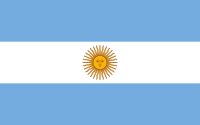 
###### https://es.wikipedia.org/wiki/Bandera_de_la_Argentina
Buenos Aires, la capital de Argentina, fue fundada dos veces, la primera en 1536 y la segunda en 1580. Buenos Aires es una ciudad conocida por su rica escena cultural, la pasión del tango, una arquitectura diversa, una deliciosa gastronomía de carnes y empanadas, una animada vida nocturna, y una profunda pasión por el fútbol. La ciudad ofrece una mezcla única de influencias europeas y latinoamericanas, con numerosos barrios distintivos como los históricos San Telmo y La Boca que atrae a visitantes de todo el mundo.  
Además, la ciudad ofrece una experiencia turística vibrante y variada que combina lo mejor de la cultura argentina con la hospitalidad de su gente y los turistas pueden explorar y visitar emblemáticos puntos de interés como el Obelisco y el Teatro Colón. 

# Introducción

Insideairbnb.com es un sitio web en el que se publican conjuntos de datos extraídos de la web de "instantáneas" de ciudades. He descargado los archivos de Buenos Aires de la situación del 3 de septiembre de 2023. Pensé que era un conjunto de datos interesante para analizar.

# 1. Importando módulos y datos

## 1.1 Importar módulos

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import os
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# mapas interactivos
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

#to make the plotly graphs
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
import plotly_express as px

#text mining
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

## 1.2 Detalles del listado de viviendas

El conjunto de datos contiene un total de 7 archivos. El archivo de listados es un archivo de descripción general que las etiquetas internas de airbnb como "bueno para visualizaciones". El identificador único en el conjunto de datos es la identificación de "listings". Esta es básicamente la identificación del anuncio. En general, había 29346 listados de Airbnb en Buenos Aires el 3 de septiembre de 2023.

In [2]:
listings = pd.read_csv("input/listings.csv", index_col= "id")
listings_details = pd.read_csv("input\listings.csv.gz", index_col= "id", low_memory=False)

calendar = pd.read_csv("input\calendar.csv.gz", parse_dates=['date'], index_col=['listing_id'])
reviews_details = pd.read_csv("input/reviews.csv.gz", parse_dates=['date'])

In [3]:
listings.shape

(29346, 17)

El archivo de listados contiene 17 variables por listado además del id.

In [4]:
listings.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'license'],
      dtype='object')

In [5]:
print(listings_details.shape)

(29346, 74)


El archivo listings_details contiene un total de 74 variables. No vamos a usar todos estos, sino que juntaremos selectivamente una serie de variables que parecen útiles para este EDA.

In [6]:
target_columns = ["property_type", "accommodates", "first_review", "review_scores_value", "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", "review_scores_communication", "review_scores_checkin", "review_scores_rating", "maximum_nights", "listing_url", "host_is_superhost", "host_about", "host_response_time", "host_response_rate", "listing_url"]
listings = pd.merge(listings, listings_details[target_columns], on='id', how='left')
listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29346 entries, 11508 to 985661520707875805
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            29346 non-null  object 
 1   host_id                         29346 non-null  int64  
 2   host_name                       29346 non-null  object 
 3   neighbourhood_group             0 non-null      float64
 4   neighbourhood                   29346 non-null  object 
 5   latitude                        29346 non-null  float64
 6   longitude                       29346 non-null  float64
 7   room_type                       29346 non-null  object 
 8   price                           29346 non-null  int64  
 9   minimum_nights                  29346 non-null  int64  
 10  number_of_reviews               29346 non-null  int64  
 11  last_review                     23841 non-null  object 
 12  reviews_per_month   

Vemos que los datos de grupo_vecindario no son útiles en Buenos Aires, ya que contiene cero objetos no nulos. A continuación, nos deshacemos de esta variable y mostramos el encabezado del marco de datos con el que vamos a trabajar.

In [7]:
listings = listings.drop(columns=['neighbourhood_group'])
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str.strip('%'))

listings.head()

name   host_id  \
id                                                                   
11508  Condo in Buenos Aires · ★4.81 · 1 bedroom · 1 ...     42762   
14222  Rental unit in Palermo/Buenos Aires · ★4.79 · ...  87710233   
15074  Rental unit in Buenos Aires · 1 bedroom · 1 be...     59338   
16695  Loft in Buenos Aires · ★4.28 · 1 bedroom · 1 b...     64880   
20062  Rental unit in Buenos Aires · ★4.93 · 2 bedroo...     75891   

           host_name neighbourhood   latitude  longitude        room_type  \
id                                                                          
11508        Candela       Palermo -34.581840 -58.424150  Entire home/apt   
14222          María       Palermo -34.586170 -58.410360  Entire home/apt   
15074         Monica         Nuñez -34.538920 -58.465990     Private room   
16695  Elbio Mariano     Monserrat -34.614390 -58.376110  Entire home/apt   
20062  Sergio Damian       Palermo -34.581848 -58.441605  Entire home/apt   

       price  minimum_nights  number_of_reviews  ...  \
id                                               ...   
11508  23753               3                 36  ...   
14222  11928               7                110  ...   
15074  10501              29                  0  ...   
16695  17501               2                 46  ...   
20062  35654               2                290  ...   

      review_scores_communication  review_scores_checkin  \
id                                                         
11508                        4.97                   4.91   
14222                        4.90                   4.81   
15074                         NaN                    NaN   
16695                        4.80                   4.83   
20062                        4.92                   4.94   

       review_scores_rating  maximum_nights  \
id                                            
11508                  4.81            1125   
14222                  4.79             100   
15074                   NaN             730   
16695                  4.28            1125   
20062                  4.93             365   

                              listing_url host_is_superhost  \
id                                                            
11508  https://www.airbnb.com/rooms/11508                 t   
14222  https://www.airbnb.com/rooms/14222                 t   
15074  https://www.airbnb.com/rooms/15074                 f   
16695  https://www.airbnb.com/rooms/16695                 f   
20062  https://www.airbnb.com/rooms/20062                 t   

                                              host_about  host_response_time  \
id                                                                             
11508                                                  -      within an hour   
14222  Soy Organizadora de Eventos, me gusta relacion...      within an hour   
15074                                                NaN                 NaN   
16695  I was borned in Tucuman, but I live in Buenos ...      within an hour   
20062  Soy Sergio, vivo en Buenos Aires, y me gusta r...      within an hour   

      host_response_rate                         listing_url  
id                                                            
11508              100.0  https://www.airbnb.com/rooms/11508  
14222              100.0  https://www.airbnb.com/rooms/14222  
15074                NaN  https://www.airbnb.com/rooms/15074  
16695              100.0  https://www.airbnb.com/rooms/16695  
20062               96.0  https://www.airbnb.com/rooms/20062  

[5 rows x 33 columns]

Hemos procedido a eliminar el barrio de Paternal de nuestro conjunto de datos debido a que es un outlier y nos desvitua el conjunto de los datos.

In [8]:
barrio_a_eliminar = "Paternal"
listings = listings[listings['neighbourhood'] != barrio_a_eliminar]

Hemos pasado el precio de $a a € y así poder ofrecer unos datos adaptados a la moneda de nuestros clientes.

In [9]:
tasa_de_cambio = 0.0027  # 1 EUR = 0,0027 $a

listings['price'] = listings['price']  * tasa_de_cambio

Una vez realizado todo el preprocesamiento pasamos al análisis.

# 2. Análisis exploratorio
## 2.1 Vecindario

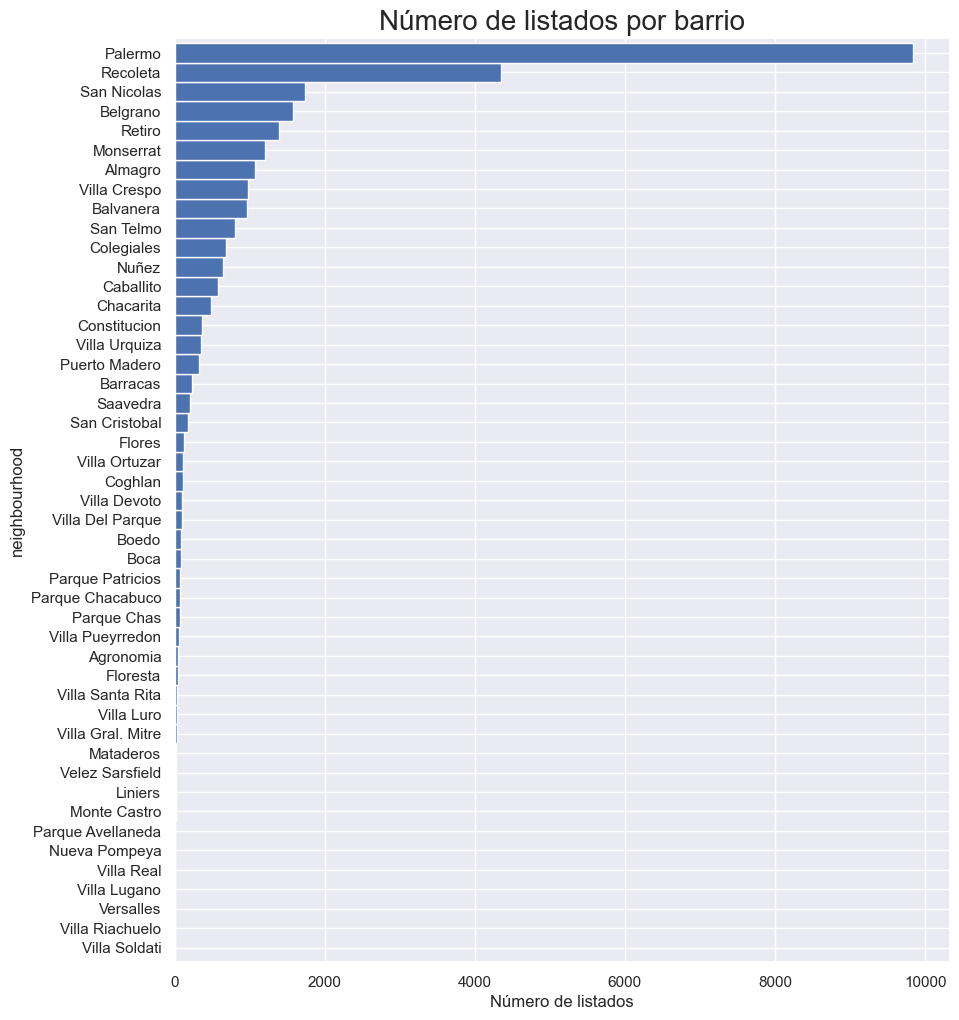

In [10]:
feq=listings['neighbourhood'].value_counts().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 12), color='b', width=1)
plt.title("Número de listados por barrio", fontsize=20)
plt.xlabel('Número de listados', fontsize=12)
plt.show()

Vemos como el mayor número de alojamientos se encuentra en Palermo, el barrio con mayor superficie de la ciudad.

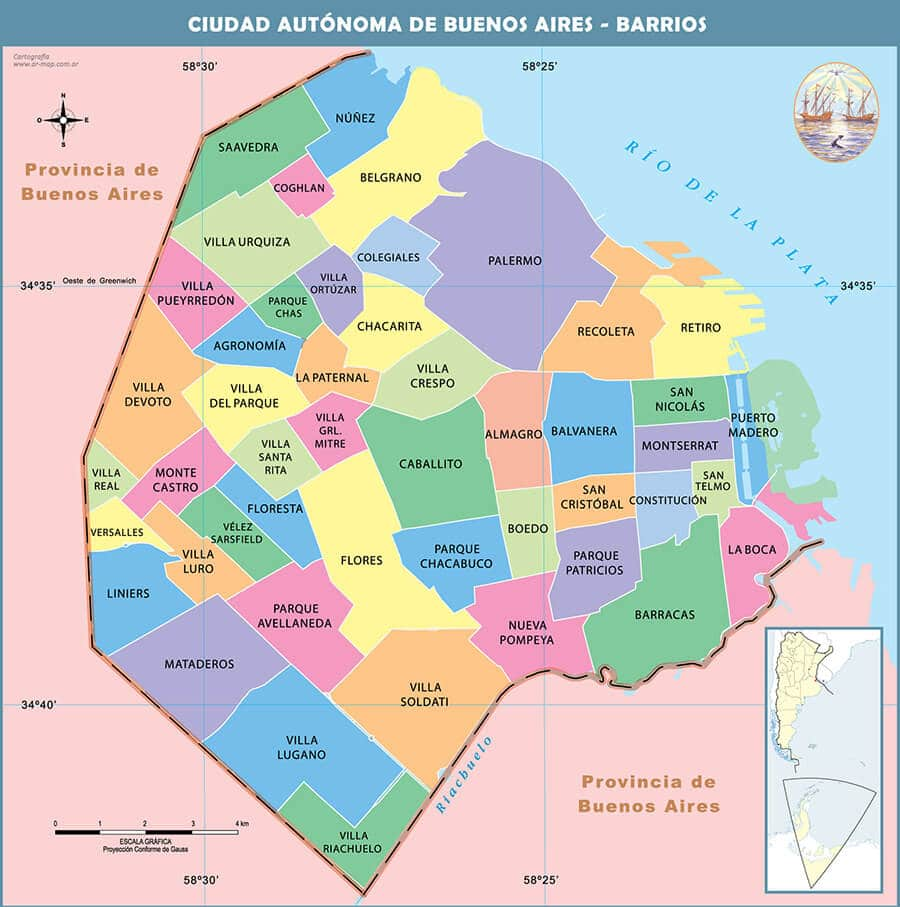
###### Fuente: https://unviajecreativo.com/seguridad-en-buenos-aires-zonas-peligrosas/

A continuación, puede ver que la mayoría de los listados están entorno al barrio de Palermo, uno de los barrios más seguros de la ciudad de Buenos Aires. Este mapa es interactivo y puede ampliar los grupos para encontrar las ubicaciones individuales de los listados.

In [11]:
lats2023 = listings['latitude'].tolist()
lons2023 = listings['longitude'].tolist()
locations = list(zip(lats2023, lons2023))

map1 = folium.Map(location=[-34.61315, -58.37723], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1

## 2.2 Tipos de propiedades y habitaciones

### 2.2.1 Tipos de habitaciones

Vemos que la mayoría de los alquileres son completos, siendo las habitaciones privadas la segunda mayor oferta en la ciudad de Buenos Aires.

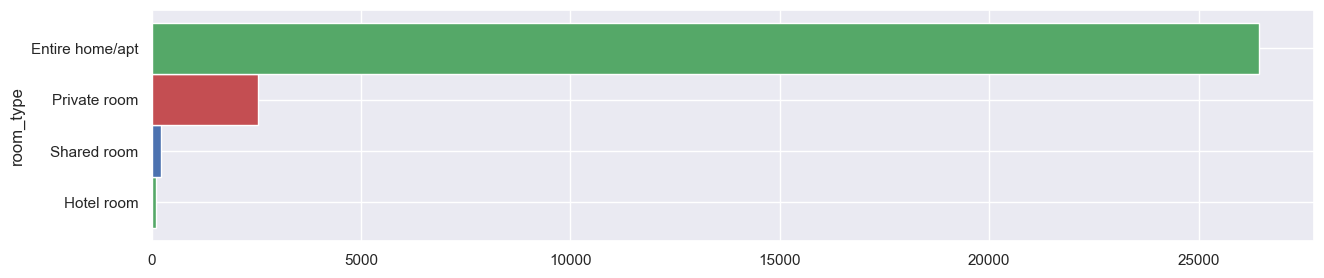

In [12]:
freq = listings['room_type']. value_counts().sort_values(ascending=True)
freq.plot.barh(figsize=(15, 3), width=1, color = ["g","b","r"])
plt.show()

### 2.2.2 Tipos de propiedades

En el conjunto de datos, encontramos muchos tipos de propiedades diferentes.

In [13]:
listings.property_type.unique()

array(['Entire condo', 'Entire rental unit',
       'Private room in rental unit', 'Entire loft', 'Entire townhouse',
       'Entire serviced apartment', 'Room in aparthotel',
       'Private room in home', 'Private room in condo',
       'Private room in casa particular', 'Entire home',
       'Private room in bed and breakfast', 'Entire villa',
       'Shared room in rental unit', 'Shared room in guest suite',
       'Camper/RV', 'Shared room in hostel', 'Private room',
       'Private room in guesthouse', 'Private room in hostel',
       'Private room in villa', 'Private room in loft',
       'Private room in serviced apartment', 'Room in hostel',
       'Private room in townhouse', 'Shared room in home',
       'Private room in guest suite', 'Room in serviced apartment',
       'Casa particular', 'Shared room in villa', 'Entire guesthouse',
       'Entire vacation home', 'Room in boutique hotel',
       'Shared room in loft', 'Entire place', 'Room in hotel',
       'Shared room in 

Sin embargo, muchos de esos tipos de propiedades tienen muy pocos listados en Buenos Aires. En la figura a continuación, solo mostramos tipos de propiedades con al menos 100 listados. Como podemos ver, la gran mayoría de las propiedades en Buenos Aires son, cmo ya hemos comentado anteriormente, alquileres completos.

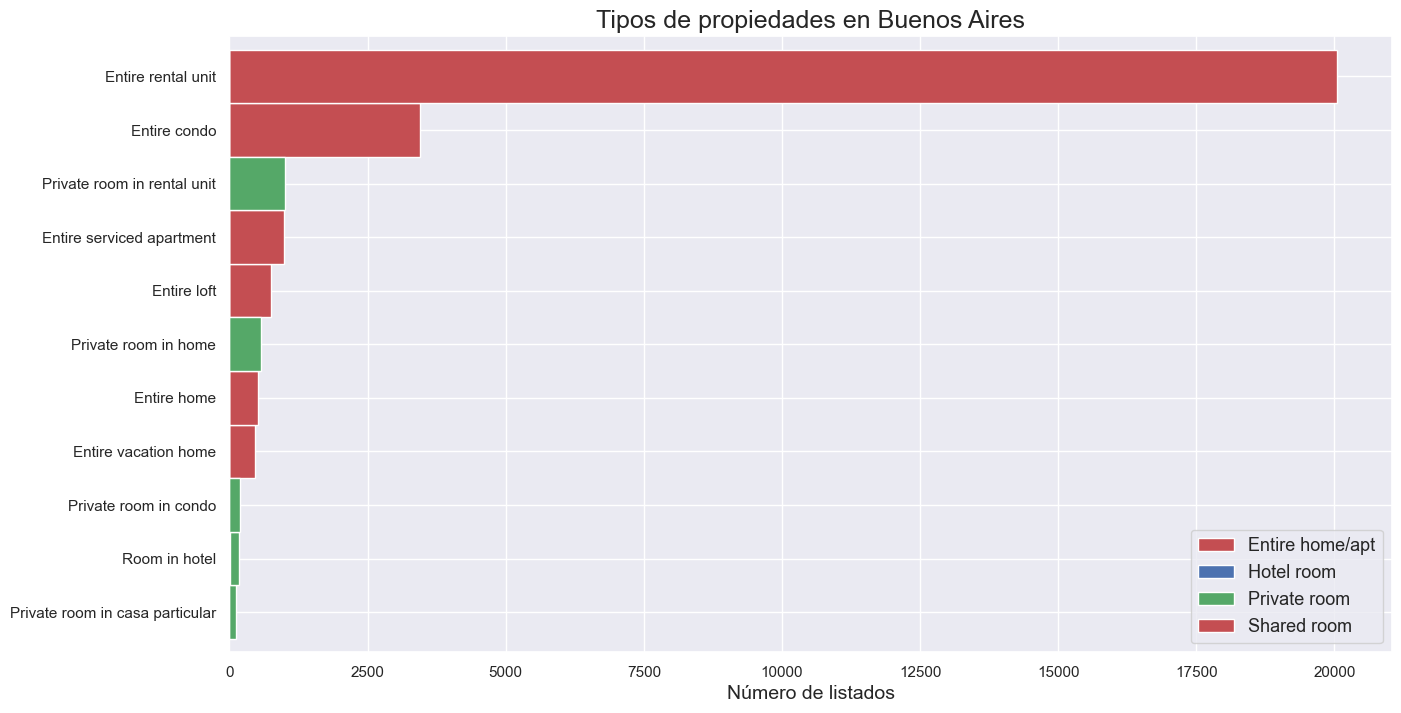

In [14]:
prop = listings.groupby(['property_type','room_type']).room_type.count()
prop = prop.unstack()
prop['total'] = prop.iloc[:,0:3].sum(axis = 1)
prop = prop.sort_values(by=['total'])
prop = prop[prop['total']>=100]
prop = prop.drop(columns=['total'])

prop.plot(kind='barh',stacked=True, color = ["r","b","g"],
              linewidth = 1, grid=True, figsize=(15,8), width=1)
plt.title('Tipos de propiedades en Buenos Aires', fontsize=18)
plt.xlabel('Número de listados', fontsize=14)
plt.ylabel("")
plt.legend(loc = 4,prop = {"size" : 13})
plt.rc('ytick', labelsize=13)
plt.show()

## 2.3 Número de alojados

Como era de esperar, la mayoría de los listados son para 2 personas. Además, Airbnb utiliza un máximo de 16 huéspedes por anuncio establecido en sus practicas responsables del anfitrión para el apartado de ruido.  
https://www.airbnb.com.ar/help/article/2986#article-content

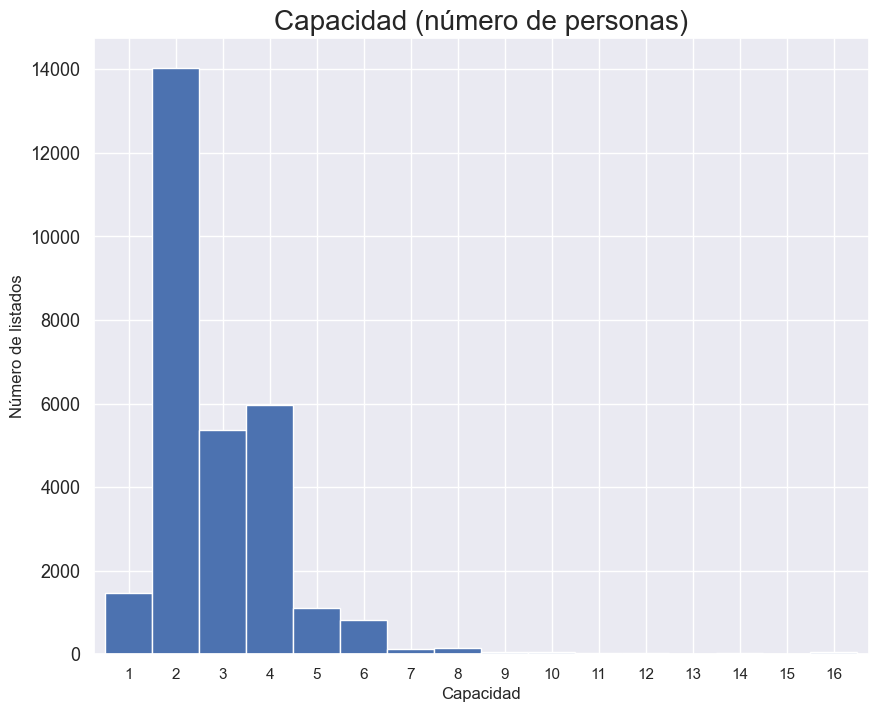

In [15]:
feq=listings['accommodates'].value_counts().sort_index()
feq.plot.bar(figsize=(10, 8), color='b', width=1, rot=0)
plt.title("Capacidad (número de personas)", fontsize=20)
plt.ylabel('Número de listados', fontsize=12)
plt.xlabel('Capacidad', fontsize=12)
plt.show()

# 3. Analítica al servicio del gobierno

Se sabe que Airbnb causa problemas en una gran cantidad de paises con respecto a los alquileres.  
Según varior aritucolos, los paises quieren entrar a regular los alquileres para frenar el descontrol en el mercado de los alquileres temporarios. A continuación dos articulos donde nos hablan de dichas circunstancias y como pueden afectar a la facturación de esta popular plataforma.  
__¿Adiós a Airbnb? Los países del mundo le ponen freno al descontrol de los alquileres temporarios y qué pasa en Argentina__ https://www.lanacion.com.ar/propiedades/inmuebles-comerciales/adios-a-airbnb-los-paises-del-mundo-le-ponen-freno-al-descontrol-de-los-alquileres-temporarios-y-que-nid24072023/  
__Airbnb | Varios países empezaron a controlar los alquileres temporarios: ¿Qué puede pasar en Argentina?:__ https://www.perfil.com/noticias/economia/varios-paises-empezaron-a-controlar-los-alquileres-temporarios-que-puede-pasar-en-argentina.phtml  
Según el diario La Nación en el artiulo mencionado anteriormente, el 73 %  permanece ocupado, en promedio, 23 de los 30 días del mes.  Además, los cinco barrios con más temporarios son Palermo (5.635), Recoleta (2.437), San Nicolás (1.046), Belgrano (833) y Retiro (803), que  representan el 66 % de la oferta en todo Buenos Aires, como hemos podido ver en la grafica representada anteriormente


## 3.1 Encontrando potenciales hoteles ilegales

A continuación, mostramos los cinco anfitriones que tienen la mayor cantidad de listas de salas privadas. Desafortunadamente, Airbnb no proporciona las direcciones de los listados. El campo "calle" está en realidad en la base de datos, pero como puede ver, ¡estas ciertamente no son direcciones reales completas! Por lo tanto, a partir de esta tabla no podemos decir si estos listados son de hecho en la misma casa, pro vemos como de los cinco anfitriones, tres con habitaciones de hoteles.

In [16]:
private = listings[listings['room_type'] == "Private room"]
host_private = private.groupby(['host_id', 'host_name', 'neighbourhood','property_type']).size().reset_index(name='private_rooms').sort_values(by=['private_rooms'], ascending=False)
host_private.head()

host_id                     host_name neighbourhood  \
1403  461271392                      Boutique       Palermo   
137     4191868  Piso Compartido Buenos Aires     Monserrat   
773   112852550                Casa Del Mundo       Palermo   
1325  401553838       Park Royal Buenos Aires        Retiro   
376    25138314           RoomPicks By Antony     Monserrat   

                    property_type  private_rooms  
1403                Room in hotel             32  
137   Private room in rental unit             28  
773          Private room in home             20  
1325                Room in hotel             18  
376                 Room in hotel             17

Sin embargo, tenemos las coordenadas GPS de los listados. Por ello, parece muy probable que todas las habitaciones privadas que ofrecen Palermo y Montserrat estén en el mismo edificio (solo variaciones menores en latitud/longitud). Aunque estos anfitriones podría tener una licencia de hotel, los datos podrían indicar que no, sus listados también parecen sospechosos (¿cuál es el nombre del hotel de Montserrat?). Aconsejaría al gobierno de Buenos Aires que compruebe si no se infringen las normas en este caso y están alimentando la problematica de los alquileres tradicionales.

In [17]:
palermo = private[private['host_id']== 112852550]
palermo = palermo[['name','host_id', 'host_name', 'latitude', 'longitude', 'license']]
palermo.index.name = "listing_id"
palermo

name  \
listing_id                                                              
40090234               Home in Palermo · 5 bedrooms · 5 beds · 1 bath   
772314009836149898  Home in Buenos Aires · 7 bedrooms · 7 beds · 4...   
861608076712377509  Home in Buenos Aires · 1 bedroom · 1 bed · 3 s...   
867986085670139960  Home in Buenos Aires · 1 bedroom · 1 bed · 3 s...   
867987285060183012  Home in Buenos Aires · 4 bedrooms · 1 bed · 3....   
868065787108936326  Home in Buenos Aires · 1 bedroom · 1 bed · 3 s...   
892078523996531391  Villa in Buenos Aires · 1 bedroom · 1 bed · 3 ...   
892097792726182771  Home in Buenos Aires · 1 bedroom · 1 bed · 3 s...   
892119833248952119  Home in Buenos Aires · 1 bedroom · 1 bed · 3 s...   
902821768262773004  Home in Buenos Aires · 8 bedrooms · 8 beds · 3...   
902939127123181874  Home in Buenos Aires · 11 bedrooms · 11 beds ·...   
904299835256690497  Home in Buenos Aires · 11 bedrooms · 11 beds ·...   
907180329600962740  Home in Buenos Aires · 11 bedrooms · 1 bed · 3...   
907212470633351314  Home in Buenos Aires · 10 bedrooms · 1 bed · 4...   
907965498567378999  Home in Buenos Aires · 7 bedrooms · 1 bed · 3 ...   
908021627193811197  Home in Buenos Aires · 8 bedrooms · 8 beds · 3...   
908051581864180172  Home in Buenos Aires · 8 bedrooms · 8 beds · 3...   
920273582175501022  Home in Buenos Aires · 8 bedrooms · 8 beds · 3...   
923863324142444285  Home in Buenos Aires · 10 bedrooms · 1 bed · 4...   
923882013938006767  Home in Buenos Aires · 10 bedrooms · 1 bed · 4...   
929563502151448922  Home in Buenos Aires · 8 bedrooms · 8 beds · 3...   
929578581336411392  Home in Buenos Aires · 7 bedrooms · 1 bed · 3 ...   
929616786920848204  Home in Buenos Aires · 7 bedrooms · 1 bed · 3 ...   
929625863848233778  Home in Buenos Aires · 7 bedrooms · 1 bed · 3 ...   
929677112377911545  Home in Buenos Aires · 10 bedrooms · 1 bed · 4...   
937747505952427451  Home in Buenos Aires · ★New · 5 bedrooms · 5 b...   
954336545518229521  Home in Buenos Aires · ★New · 7 bedrooms · 1 b...   

                      host_id       host_name   latitude  longitude license  
listing_id                                                                   
40090234            112852550  Casa Del Mundo -34.583090 -58.440040     NaN  
772314009836149898  112852550  Casa Del Mundo -34.596214 -58.423265     NaN  
861608076712377509  112852550  Casa Del Mundo -34.594993 -58.429664     NaN  
867986085670139960  112852550  Casa Del Mundo -34.580407 -58.435754     NaN  
867987285060183012  112852550  Casa Del Mundo -34.580407 -58.435754     NaN  
868065787108936326  112852550  Casa Del Mundo -34.580407 -58.435754     NaN  
892078523996531391  112852550  Casa Del Mundo -34.580407 -58.435756     NaN  
892097792726182771  112852550  Casa Del Mundo -34.580407 -58.435756     NaN  
892119833248952119  112852550  Casa Del Mundo -34.580407 -58.435756     NaN  
902821768262773004  112852550  Casa Del Mundo -34.596214 -58.423264     NaN  
902939127123181874  112852550  Casa Del Mundo -34.580019 -58.436421     NaN  
904299835256690497  112852550  Casa Del Mundo -34.580407 -58.435756     NaN  
907180329600962740  112852550  Casa Del Mundo -34.580407 -58.435756     NaN  
907212470633351314  112852550  Casa Del Mundo -34.579808 -58.438492     NaN  
907965498567378999  112852550  Casa Del Mundo -34.594993 -58.429664     NaN  
908021627193811197  112852550  Casa Del Mundo -34.596166 -58.423258     NaN  
908051581864180172  112852550  Casa Del Mundo -34.596214 -58.423264     NaN  
920273582175501022  112852550  Casa Del Mundo -34.596214 -58.423264     NaN  
923863324142444285  112852550  Casa Del Mundo -34.579808 -58.438492     NaN  
923882013938006767  112852550  Casa Del Mundo -34.579808 -58.438492     NaN  
929563502151448922  112852550  Casa Del Mundo -34.596214 -58.423264     NaN  
929578581336411392  112852550  Casa Del Mundo -34.594993 -58.429664     NaN  
929616786920848204  112852550  Casa Del Mundo -34.594993 -58.429664     NaN

In [18]:
montserrat = private[private['host_id']== 4191868]
montserrat = montserrat[['name','host_id', 'host_name', 'latitude', 'longitude', 'license']]
montserrat.index.name = "listing_id"
montserrat

name  \
listing_id                                                              
795812              Rental unit in Buenos Aires · ★5.0 · 4 bedroom...   
8881075             Rental unit in Buenos Aires · ★4.71 · 4 bedroo...   
12407085            Rental unit in Buenos Aires · ★4.86 · 4 bedroo...   
12407416            Rental unit in Buenos Aires · ★4.22 · 1 bedroo...   
39354797            Rental unit in Monserrat · ★4.56 · 1 bedroom ·...   
39547331            Rental unit in AAS · ★5.0 · 4 bedrooms · 1 bed...   
40222518            Rental unit in AAS · ★4.67 · 4 bedrooms · 1 be...   
40248804            Rental unit in AAS · ★4.86 · 1 bedroom · 1 bed...   
41468505            Rental unit in AAS · ★5.0 · 1 bedroom · 1 bed ...   
41615566            Rental unit in AAS · ★4.60 · 4 bedrooms · 1 be...   
47714335            Condo in AAS · ★4.67 · 1 bedroom · 1 bed · 1.5...   
53824682            Rental unit in Monserrat · ★4.40 · 4 bedrooms ...   
53931196            Rental unit in Monserrat · 4 bedrooms · 1 bed ...   
54034258            Rental unit in Monserrat · ★4.63 · 3 bedrooms ...   
54034660            Rental unit in Monserrat · ★4.29 · 3 bedrooms ...   
54034862            Rental unit in Monserrat · ★5.0 · 3 bedrooms ·...   
562151229261404625  Rental unit in Monserrat · 4 bedrooms · 1 bed ...   
618115599362277994  Rental unit in Monserrat · 3 bedrooms · 2 beds...   
628767170845290020  Rental unit in Monserrat · 4 bedrooms · 1 bed ...   
628776950291794362  Rental unit in Monserrat · 3 bedrooms · 1 bed ...   
628782585858610902  Rental unit in Monserrat · 3 bedrooms · 1 bed ...   
630277024636367479  Rental unit in Monserrat · 3 bedrooms · 1 bed ...   
670091590657814740  Rental unit in Monserrat · 4 bedrooms · 1 bed ...   
670108939492574948  Rental unit in Monserrat · 4 bedrooms · 1 bed ...   
670213527272136387  Rental unit in Monserrat · 4 bedrooms · 1 bed ...   
670220830550219668  Rental unit in Monserrat · 4 bedrooms · 1 bed ...   
772523888543846129  Rental unit in Buenos Aires · 3 bedrooms · 1 b...   
852111805295444368  Rental unit in Buenos Aires · 3 bedrooms · 1 b...   
892731040765555632  Rental unit in Buenos Aires · 4 bedrooms · 1 b...   

                    host_id                     host_name   latitude  \
listing_id                                                             
795812              4191868  Piso Compartido Buenos Aires -34.615410   
8881075             4191868  Piso Compartido Buenos Aires -34.617070   
12407085            4191868  Piso Compartido Buenos Aires -34.617360   
12407416            4191868  Piso Compartido Buenos Aires -34.615700   
39354797            4191868  Piso Compartido Buenos Aires -34.617310   
39547331            4191868  Piso Compartido Buenos Aires -34.617410   
40222518            4191868  Piso Compartido Buenos Aires -34.617210   
40248804            4191868  Piso Compartido Buenos Aires -34.617530   
41468505            4191868  Piso Compartido Buenos Aires -34.616020   
41615566            4191868  Piso Compartido Buenos Aires -34.617400   
47714335            4191868  Piso Compartido Buenos Aires -34.616930   
53824682            4191868  Piso Compartido Buenos Aires -34.617490   
53931196            4191868  Piso Compartido Buenos Aires -34.615270   
54034258            4191868  Piso Compartido Buenos Aires -34.617030   
54034660            4191868  Piso Compartido Buenos Aires -34.617280   
54034862            4191868  Piso Compartido Buenos Aires -34.615450   
562151229261404625  4191868  Piso Compartido Buenos Aires -34.615640   
618115599362277994  4191868  Piso Compartido Buenos Aires -34.617420   
628767170845290020  4191868  Piso Compartido Buenos Aires -34.616690   
628776950291794362  4191868  Piso Compartido Buenos Aires -34.615850   
628782585858610902  4191868  Piso Compartido Buenos Aires -34.617460   
630277024636367479  4191868  Piso Compartido Buenos Aires -34.615400   
670091590657814740  4191868  Piso Compartido Buenos Aires -34.617410   
6

In [19]:
map2 = folium.Map(location=[-34.617150,	-58.378724], zoom_start=17)
for coord in montserrat.itertuples(index=False):
    folium.Marker((coord.latitude, coord.longitude), tooltip=coord.name).add_to(map2)
map2

## 3.2 Efectos no deseados de los anfitriones profesionales?

Por el momento, Buenos Aires no tiene ninguna regla vigente para impedir las actividades de alojamiento profesional, de hecho, vemos como hay gente dedicada a ello. Por el momento, alrededor del 75% de los anfitriones solo tienen un listado. Supondremos que los anfitriones con solo un par de listados probablemente también sean anfitriones de un par de amigos, algo que no podemos afirmar. Sin embargo, vemos que hay casos donde parece poco probable que los anfitriones con más de 10 listados solo hagan esto para ellos, sus amigos y familiares, sino que sea gente dedicada profesionalmente al alquiler de los mismos.

In [20]:
freq = listings.groupby(['host_id']).size().reset_index(name='num_host_listings')
host_prop = freq.groupby(['num_host_listings']).size().reset_index(name='count').transpose()
host_prop.columns = host_prop.iloc[0]
host_prop = host_prop.drop(host_prop.index[0])
host_prop

num_host_listings    1     2    3    4    5    6    7    8    9    10   ...  \
count              11463  1755  615  331  174   90   81   60   63   25  ...   

num_host_listings  114  118  119  121  133  146  147  163  170  205  
count                1    1    1    1    1    1    1    1    1    1  

[1 rows x 72 columns]

A continuación, mostramos los anfitriones con más de 20 listados. Como este conjunto de datos es extremadamente reciente, no fue difícil para mí encontrar la descripción del host con más de 200 listados en airbnb.com. Como puede ver, este anfitrión es un anfitrión profesional.  
https://fliphaus.com/es/

Como probablemente sea difícil implementar y controlar una medida que prohíba por completo las actividades de alojamiento profesional, recomendaría al municipio de Buenos Aires que considerara establecer un número máximo de listados por host, debido al creciente problema que se está sufriendo para poder alquilar una vivinda. Si Buenos Aires estableciera esto en, por ejemplo, 10 (y logra que esto se implemente en los sistemas de Airbnb), sería mucho más difícil explotar el hospedaje en Airbnb como una actividad profesional y haría más fácil el acceso a la vivienda, donde los propietarios ven más rentables los temporarios que los tradicionales.  
https://www.notaalpie.com.ar/2023/02/16/airbnb-agrava-los-problemas-de-vivienda-en-buenos-aires/  


In [21]:
freq = listings.groupby(['host_id', 'host_name', 'host_about']).size().reset_index(name='num_host_listings')
freq = freq.sort_values(by=['num_host_listings'], ascending=False)
freq = freq[freq['num_host_listings'] >= 20]
freq

host_id            host_name  \
246     1021694             Fliphaus   
1552   11256892            HomelyJoy   
3018   51699880               Lorena   
5462  278440549  Boutique Apartments   
668     3469227             Federico   
...         ...                  ...   
386     1751072                Diego   
881     4986026              Heloise   
5496  287853027                  One   
2412   30700159              Mariana   
2904   48164656                  Syl   

                                             host_about  num_host_listings  
246   Hola!\n\nSomos FLIPHAUS! \n\nGestionamos mas d...                205  
1552  We love the World and travel on it. We always ...                170  
3018  Somos Lore y Fede y seremos tus anfitriones . ...                147  
5462  Hi and greetings from the Boutique Apartments ...                146  
668               Soy de Buenos Aires, capital federal                 133  
...                                                 ...                ...  
386   I've been living in Buenos Aires  for almost 9...                 21  
881   Vivo en Buenos Aires hace 13 anos, ayudando la...                 21  
5496  ONE TEMPORARY cuenta con más de ocho años en e...                 21  
2412  Hola! \n\nMe llamo Mariana y hace muchos mucho...                 20  
2904  Hey there Airbnbers. I'm Syl! and  I'm here to...                 20  

[93 rows x 4 columns]

En el siguiente enlace podemos ver como Fliphaus es un anfitrión reputado dentro de la plaforma de Airbnb.  
https://es-l.airbnb.com/rooms/831243719133761286?source_impression_id=p3_1698424467_FOmn1i%2BlgBfeQDnu(URL)

_Anfitrión: Fliphaus_  
_Se registró en agosto de 2011_  
_7817 reseñas_  
_Identidad verificada_  

_Hola! Somos FLIPHAUS! Descansando en 250 viviendas en Buenos Aires. Contamos en la ciudad de Buenos Aires. Vivienda en 6.500 viviendas en 250 viviendas en Buenos Aires. En 2023, Comenzamos A trabajar nuevas propiedades en Mendoza! No dudes en contactarnos! Te esperamos !_

# 4. Consejos al turismo

## 4.1 Precio medio por vecindario

Vamos a comparar por barrios y posteriormente solo seleccionaremos el tipo de alojamiento más común, que es el alojamiento para 2 personas. Como podemos ver, en un contexto global, sería el barrio de Coghlan, mientras que en el alojamiento para dos personas pasa a ser Colegiales.

In [22]:
precio_promedio = listings['price'].mean()
print("Precio promedio:", precio_promedio)

Precio promedio: 63.73732646687375


Aquí tenemos el precio medio por barrio y en la siguiente gráfica lo analizaremos para alojamientos de dos personas.

In [23]:
precio = listings.groupby('neighbourhood')['price'].mean().sort_values(ascending = True)
dfprecio = pd.DataFrame(precio)
dfprecio = dfprecio.reset_index()

px.treemap(dfprecio,path=["neighbourhood"],values="price", template= "plotly_dark", title="Precio promedio diario según ubicación en Buenos Aires" )

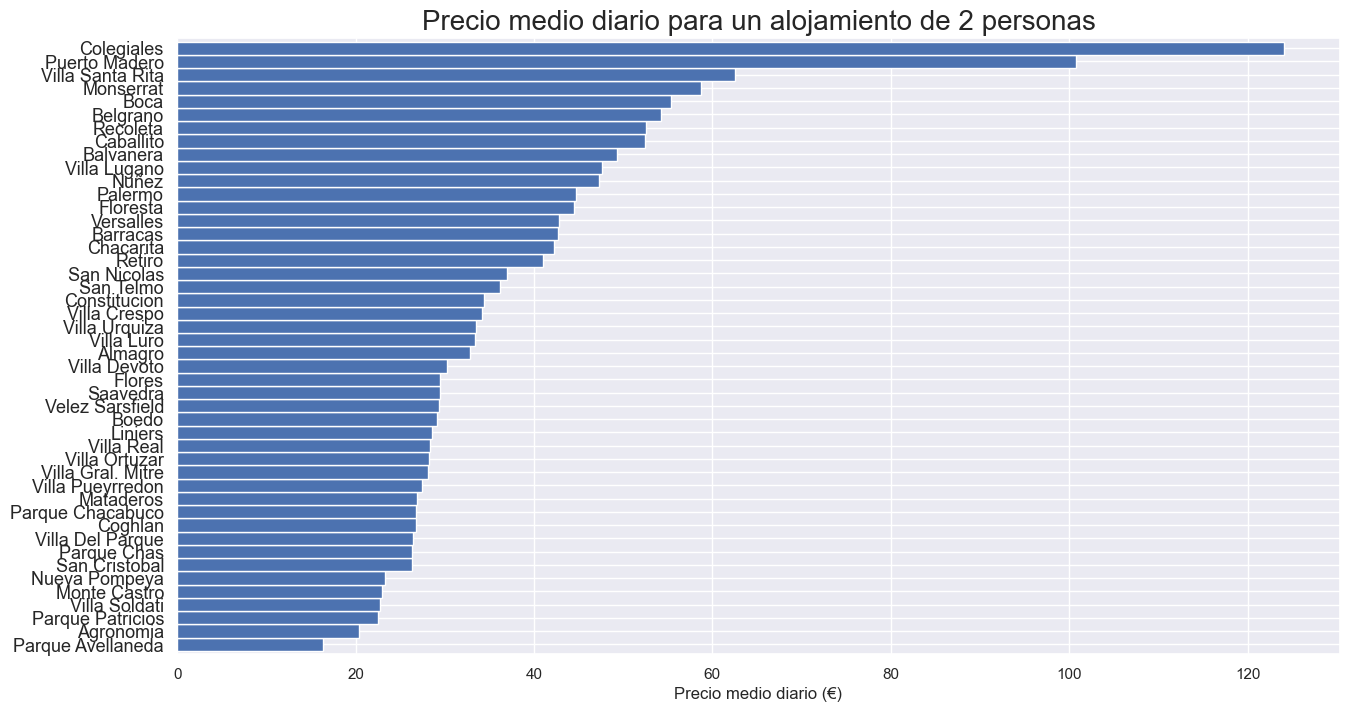

In [24]:
feq = listings[listings['accommodates']==2]
feq = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
feq.plot.barh(figsize=(15, 8), color='b', width=1)
plt.title("Precio medio diario para un alojamiento de 2 personas", fontsize=20)
plt.xlabel('Precio medio diario (€)', fontsize=12)
plt.ylabel("")
plt.show()

Y su distribución en la ciudad

In [25]:
feq = listings[listings['accommodates']==2]
feq = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)

ba = gpd.read_file("input/neighbourhoods.geojson")
 
feq = feq.transpose()
ba = pd.merge(ba, feq, on='neighbourhood', how='left')
ba.rename(columns={'price': 'average_price'}, inplace=True)
ba.average_price = ba.average_price.round(decimals=2)
ba = ba.dropna(subset=['average_price'])
 
map_dict = ba.set_index('neighbourhood')['average_price'].to_dict()
# Specify sorted color scale thresholds
min_value = min(map_dict.values())
max_value = max(map_dict.values())
thresholds = [min_value, max_value]  # You can adjust this based on your desired color range.

# # Sort the thresholds
thresholds.sort()

# Create the color scale
# color_scale = LinearColormap(['yellow', 'red'], vmin=min_value, vmax=max_value, max_labels=10)
color_scale = LinearColormap(['yellow','red'], vmin=thresholds[0], vmax=thresholds[1])
# color_scale = LinearColormap(['yellow','red'], vmin = min(map_dict.values()), vmax = max(map_dict.values()))
 
def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    if value is not None:
        return color_scale(value)
    else:
        return 'grey'
    
map3 = folium.Map(location=[-34.61315, -58.37723], zoom_start=12)

folium.GeoJson(data=ba,
               name='Buenos Aires',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'average_price'],
                                                      labels=True,
                                                      sticky=True),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.9
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.8}).add_to(map3)
map3

## 4.2 Seguridad del vecindario

Como no hay datos sobre la seguridad del vecindario en los archivos de Airbnb, Google se pueden encontrar datos adicionales al respecto, pero no actualizados al 100%.

En la ciudad de Buenos Aires existen barrios más seguros que otros. Existen algunos barrios seguros en Buenos Aires donde se cometen menos robos, asaltos o delitos. Uno de los barrios más seguros es Recoleta, una de las zonas más caras de Buenos Aires. Justamente, es por las calles de Recoleta que a la ciudad se la compara con París. Muchos hoteles 5 estrellas están por esta zona como restaurantes, tiendas y joyerías de alta gama. Este barrio es de los más seguros de Buenos Aires.

Palermo es otro de los barrios mejor catalogados en términos de seguridad en Buenos Aires. Este barrio es una zona residencial muy grande que se divide, a su vez, en áreas: Palermo Viejo, Palermo Chico, Palermo Soho y Palemo Hollywood. Puerto Madero, además de ser otro barrio seguro mantiene un estilo moderno y europeo. Barrio con detalles impecables, está repleto de hoteles 5 estrellas y residencias de alto poder adquisitivo. La seguridad es permanente aquí.

Caballito, Parque Patricios y Chacarita también cuentan como barrios seguros en Buenos Aires. Además, son barrios menos costosos para vivir que los tres nombrados anteriormente. Estas tres zonas son más tranquilas y cuentan con zonas muy lindas como el Monumento al Cid Emperador y el Parque Centenario.  

###### Fuente: https://www.argentinatranquila.com/barrios-seguros-en-buenos-aires.php

Además, podemos encontrar información más actualizada en el lo que se conoce como mapa del delito elaborado por el Ministerio de Justicia y Seguridad
Subsecretaría de Seguridad Comunal e Investigación Criminal. A continuación, el informe de estadistica criminal correspondiente al perido 2016 - 2021.  
https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-justicia-y-seguridad/delitos/Informe_complementario.pdf

A la luz de toda la información recopilada, hay que extremar las precauciones a la hora de llevar las pertenencias e intentar no salirse de las vías más concurridas ni entrar en las villas (sitios que se detectan al tener casas bajas de chapa), que hay en alguna de las columnas en la que se encuentra dividida la ciudad. Aquí un informe más actualizado sobre la inseguridad en Buenos Aires  
https://www.infobae.com/politica/2023/04/29/mapa-de-la-inseguridad-en-la-provincia-de-buenos-aires-aumentaron-los-delitos-y-hubo-un-descenso-leve-de-los-homicidios/

Además, en la siguiente imagen podemos ver un analisis más general de manera visual basada en la opinión de los usuarios, por lo que no se podría considerar información oficial al poder estar sesgada.
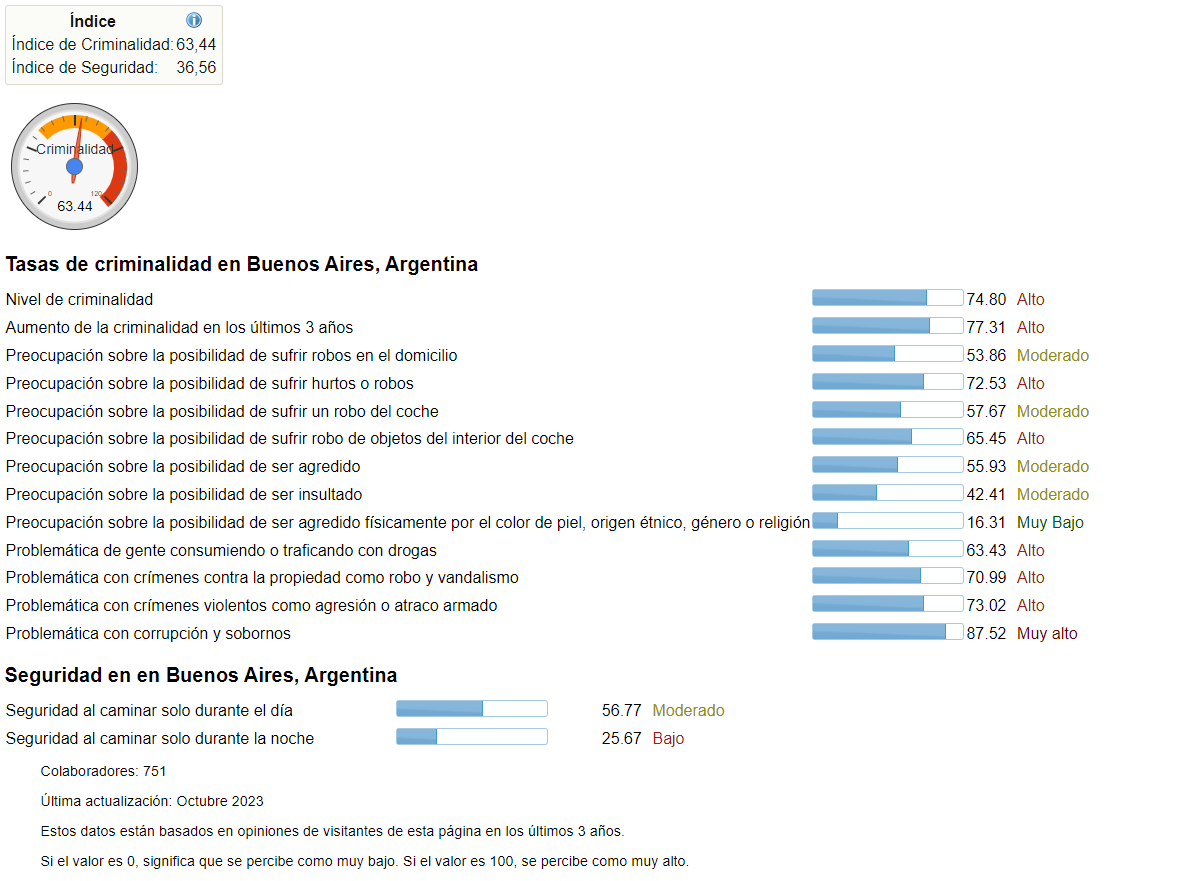
###### Fuente: https://es.numbeo.com/criminalidad/ciudad/Buenos-Aires (aportación de Jaime Vecina)

## 4.3 Review scores location, and location scores versus price

En esta sección, agrupamos los puntajes de revisión de la ubicación por vecindario (solo listados con al menos 10 revisiones). Aunque esperamos que la distancia al centro de la ciudad sea un factor importante, esta puntuación también debería tener en cuenta otros factores.

A continuación, vemos que los vecindarios mas cercanos a la costa, que no necesariamente fueron los más caros, también obtienen una puntuación más alta en la puntuación de revisión de ubicación.

Al mirar la puntuación promedio, me sorprende ver que el promedio en una escala de 0-5 está por encima del 4, teniendo en cuanta que no guarda relación directa, en la mayoría de los casos, el precio con las valoraciones, siendo un dato que demuestra que no siempre más es mejor.

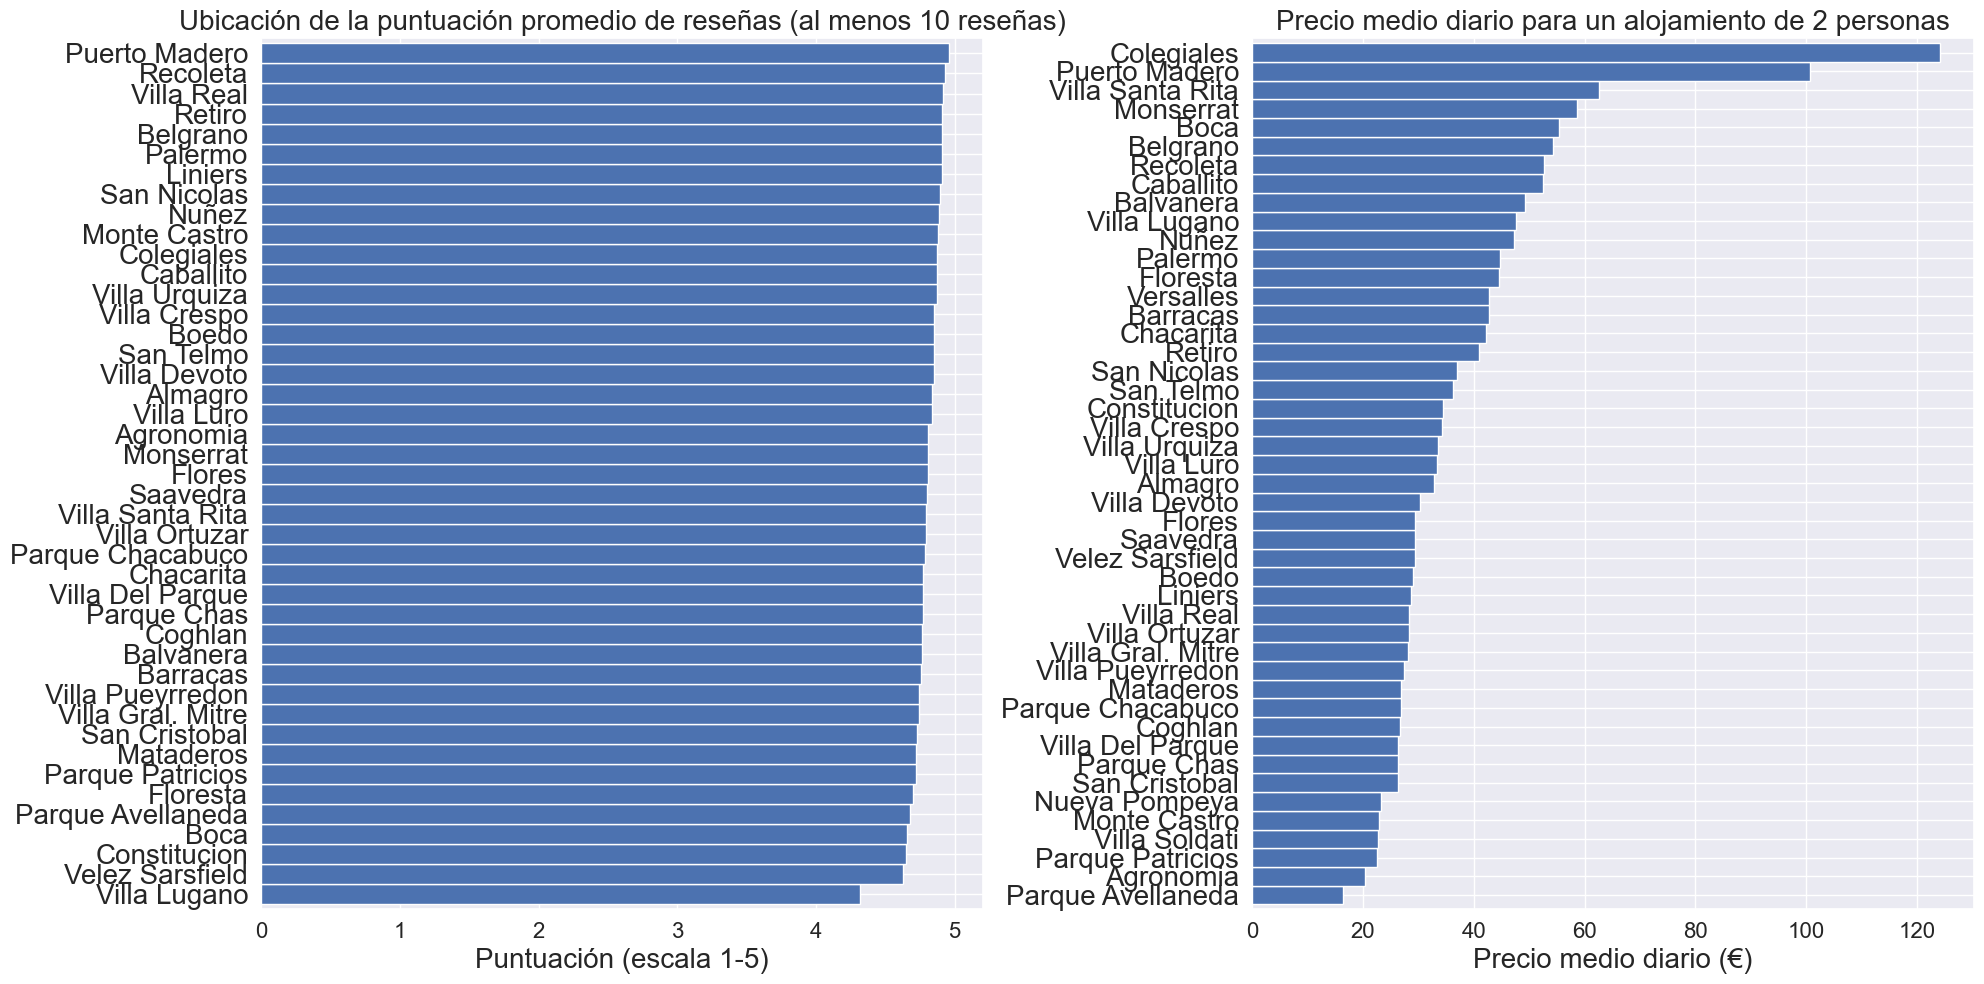

In [26]:
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq = listings[listings['number_of_reviews']>=10]
feq1 = feq.groupby('neighbourhood')['review_scores_location'].mean().sort_values(ascending=True)
ax1=feq1.plot.barh(color='b', width=1)
plt.title("Ubicación de la puntuación promedio de reseñas (al menos 10 reseñas)", fontsize=20)
plt.xlabel('Puntuación (escala 1-5)', fontsize=20)
plt.ylabel("")

ax2 = fig.add_subplot(122)
feq = listings[listings['accommodates']==2]
feq2 = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
ax2=feq2.plot.barh(color='b', width=1)
plt.title("Precio medio diario para un alojamiento de 2 personas", fontsize=20)
plt.xlabel('Precio medio diario (€)', fontsize=20)
plt.ylabel("")

plt.tight_layout()
plt.show()

## 4.4 Cómo usar las puntuaciones de las opiniones

Además de las reseñas escritas, los invitados pueden enviar una calificación de estrellas general y un conjunto de calificaciones de estrellas de categoría. Los huéspedes pueden dar calificaciones sobre:

* Experiencia general. ¿Cuál fue su experiencia en general?
* Limpieza. ¿Sentiste que tu espacio estaba limpio y ordenado?
* Precisión. ¿Con qué precisión su página de listado representó su espacio?
* Valor. ¿Sintió que su listado proporcionó un buen valor por el precio?
* Comunicación. ¿Qué tan bien se comunicó con su anfitrión antes y durante su estadía?
* Llegada. ¿Qué tan bien fue su registro?
* Ubicación. ¿Cómo te sentiste en el barrio?

A continuación puede ver la distribución de puntajes de todas esas categorías. ¡Lo que me llamó la atención de inmediato es que las puntuaciones parecen realmente altas en todos los ámbitos!. Está bien explicado en este artículo: [¿Más alta que la calificación promedio? El 95 % de los listados de Airbnb calificaron de 4,5 a 5 estrellas](https://mashable.com/2015/02/25/airbnb-reviews-above-average/?europe=true#1YLfzOC34sqd).

Después de haber visto las distribuciones de puntuación, personalmente consideraría que cualquier puntción de 4,5 o inferior no es una buena puntuación.

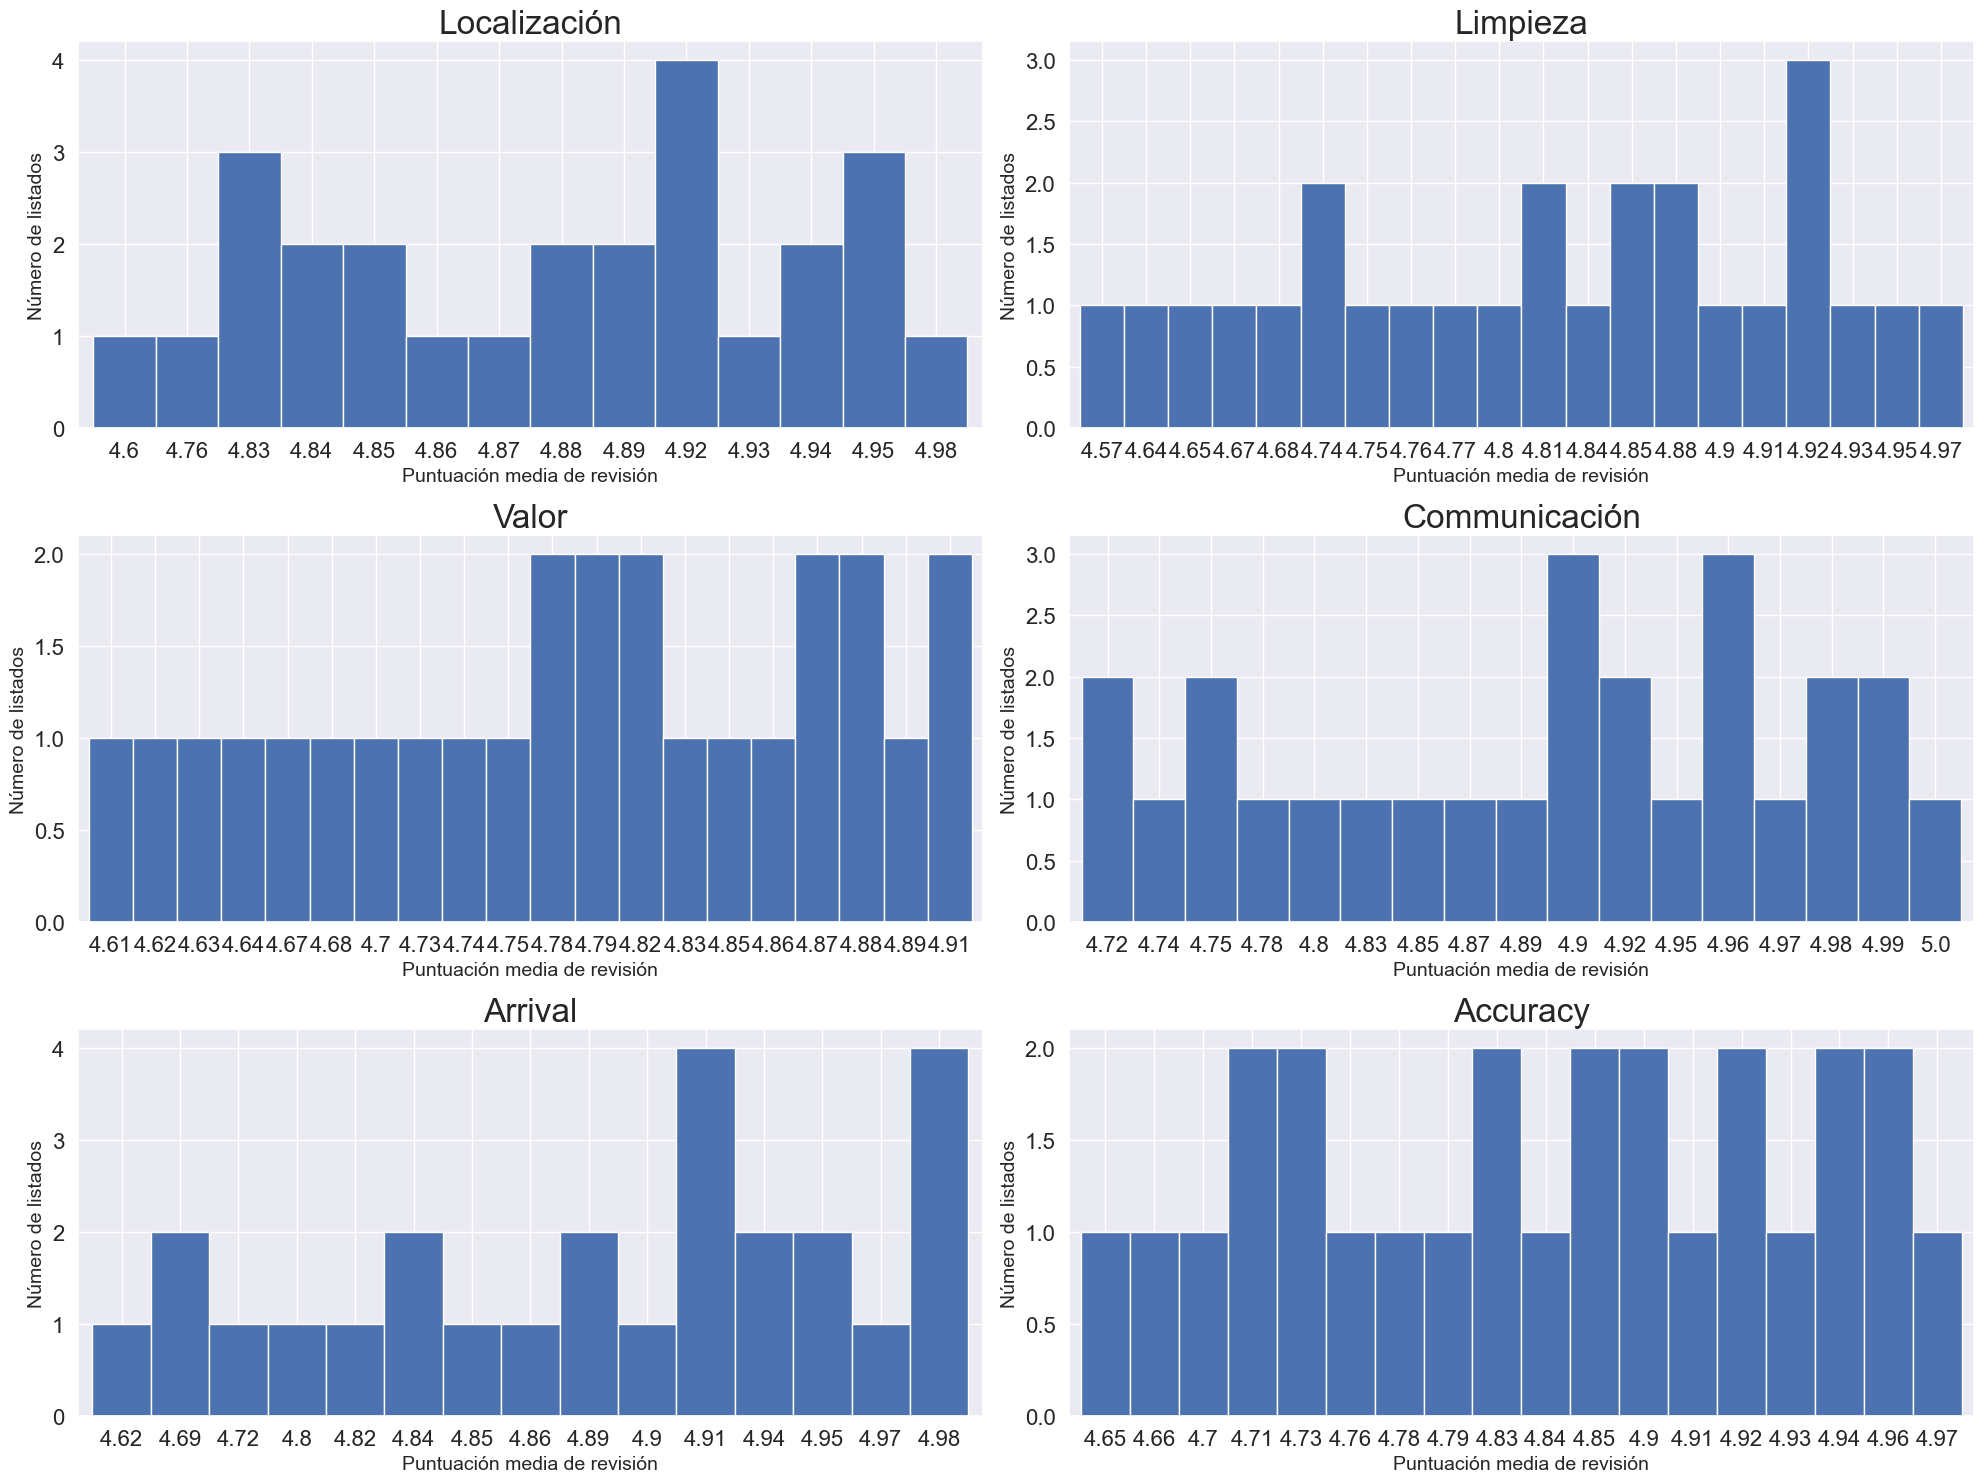

In [27]:
listings10 = listings[listings['number_of_reviews']>=350]

fig = plt.figure(figsize=(20,15))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

ax1 = fig.add_subplot(321)
feq=listings10['review_scores_location'].value_counts().sort_index()
ax1=feq.plot.bar(color='b', width=1, rot=0)
ax1.tick_params(axis = 'both', labelsize = 16)
plt.title("Localización", fontsize=24)
plt.ylabel('Número de listados', fontsize=14)
plt.xlabel('Puntuación media de revisión', fontsize=14)

ax2 = fig.add_subplot(322)
feq=listings10['review_scores_cleanliness'].value_counts().sort_index()
ax2=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Limpieza", fontsize=24)
plt.ylabel('Número de listados', fontsize=14)
plt.xlabel('Puntuación media de revisión', fontsize=14)

ax3 = fig.add_subplot(323)
feq=listings10['review_scores_value'].value_counts().sort_index()
ax3=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Valor", fontsize=24)
plt.ylabel('Número de listados', fontsize=14)
plt.xlabel('Puntuación media de revisión', fontsize=14)

ax4 = fig.add_subplot(324)
feq=listings10['review_scores_communication'].value_counts().sort_index()
ax4=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Communicación", fontsize=24)
plt.ylabel('Número de listados', fontsize=14)
plt.xlabel('Puntuación media de revisión', fontsize=14)

ax5 = fig.add_subplot(325)
feq=listings10['review_scores_checkin'].value_counts().sort_index()
ax5=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Arrival", fontsize=24)
plt.ylabel('Número de listados', fontsize=14)
plt.xlabel('Puntuación media de revisión', fontsize=14)

ax6 = fig.add_subplot(326)
feq=listings10['review_scores_accuracy'].value_counts().sort_index()
ax6=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Accuracy", fontsize=24)
plt.ylabel('Número de listados', fontsize=14)
plt.xlabel('Puntuación media de revisión', fontsize=14)

plt.tight_layout()
plt.show()

## 4.5 Encontrando un buen hospedador

En Airbnb puedes obtener el estatus de "Superhost". De Airbnb:
* Como SuperAnfitrión, tendrá más visibilidad, potencial de ingresos y recompensas exclusivas. Es nuestra manera de decir gracias por su hospitalidad excepcional.
* Cómo convertirse en Superhost: cada 3 meses, verificamos si cumple con los siguientes criterios. Si lo haces, ganarás o mantendrás tu estatus de SuperAnfitrión.
    * Los Superanfitriones tienen una calificación general promedio de 4.8 o superior según las reseñas de al menos el 50 % de sus huéspedes de Airbnb durante el último año.
    * Los Superhosts han alojado al menos 10 estadías en el último año o, si realizan reservas a más largo plazo, 100 noches en al menos 3 estadías.
    * Los Superhosts no tienen cancelaciones en el último año, a menos que haya circunstancias atenuantes.
    * Los Superhosts responden al 90 % de los mensajes nuevos en 24 horas.

A continuación, podemos ver como aproximadamente la mitad de los listados en Buenos Aires tienen un anfitrión que es Superanfitrión.

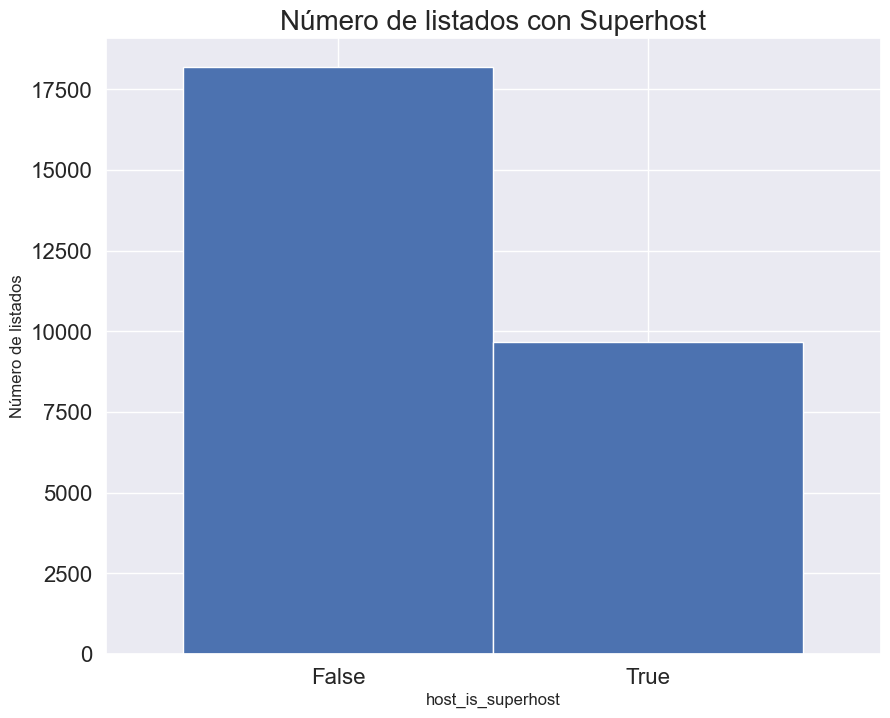

In [28]:
listings.host_is_superhost = listings.host_is_superhost.replace({"t": "True", "f": "False"})

feq=listings['host_is_superhost'].value_counts()
feq.plot.bar(figsize=(10, 8), width=1, rot=0)
plt.title("Número de listados con Superhost", fontsize=20)
plt.ylabel('Número de listados', fontsize=12)
plt.show()

Si tuviéramos que reservar alojamiento, no buscaríamos necesariamente un superhost. En realidad, acabaríamos pagando un sobre-coste innecesario que no garantiza un mejor servicio, ya que el superhost probablemente aumentará sus precios al tener ese estatus. Sin embargo, tampoco me gustaría un host que no cumpliera con las expectativas y tardase en responder.

Como podemos ver, más de 5.000 de los 20.000 listados tienen al menos 10 reseñas y responden al menos al 90% de los mensajes nuevos. Consideraría que esos anfitriones responden de manera rápida y correcta (lo que no significa que una lista con menos de 10 reseñas no pueda tener buenos anfitriones que respondan). Además, hay muy pocos listados con anfitriones que no respondan a los mensajes nuevos dentro de las 24 horas, siendo una practica habitual entre los hospedadores.

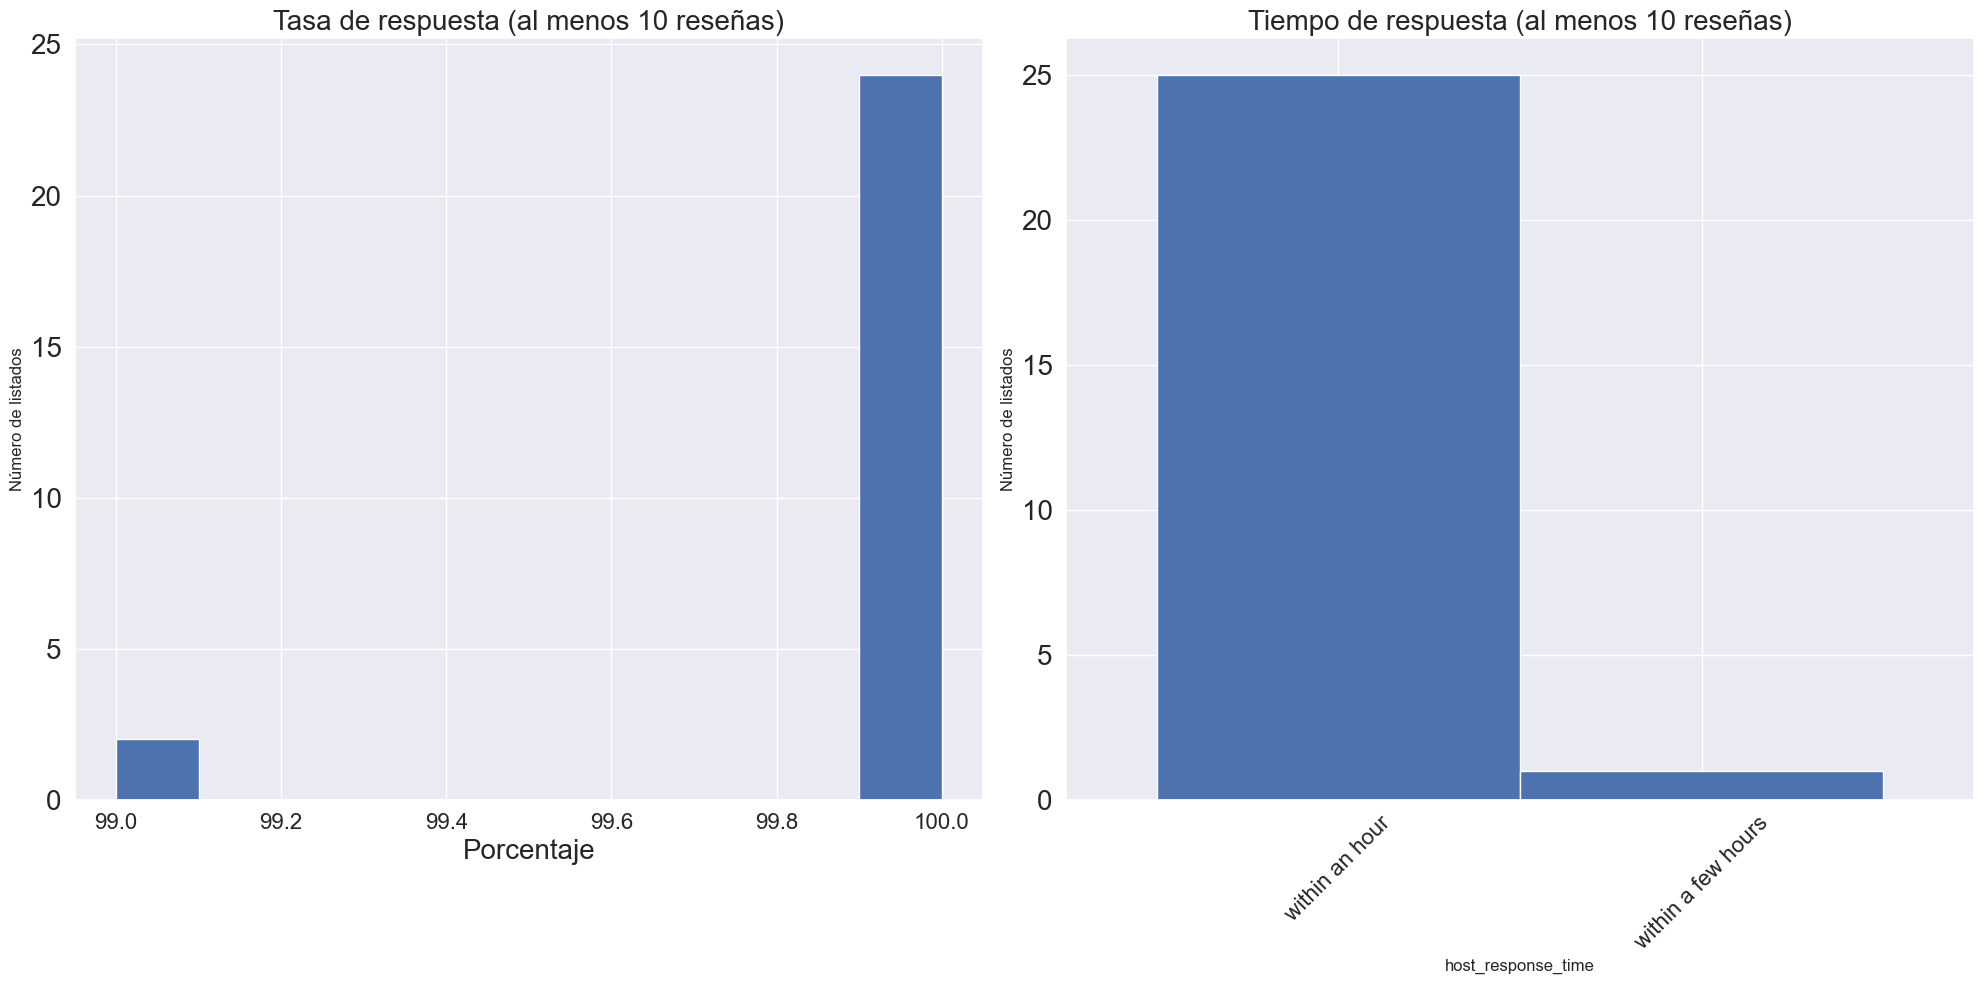

In [29]:
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq1 = listings10['host_response_rate'].dropna()
ax1= plt.hist(feq1)
plt.title("Tasa de respuesta (al menos 10 reseñas)", fontsize=20)
plt.ylabel("Número de listados")
plt.xlabel("Porcentaje", fontsize=20)

ax2 = fig.add_subplot(122)
feq2 = listings10['host_response_time'].value_counts()
ax2=feq2.plot.bar(color='b', width=1, rot=45)
plt.title("Tiempo de respuesta (al menos 10 reseñas)", fontsize=20)
plt.ylabel("Número de listados")

plt.tight_layout()
plt.show()

## 4.6 Disponibilidad en el tiempo

El archivo de calendario contiene 365 registros para cada listado, lo que significa que para cada listado, el precio y la disponibilidad por fecha se especifican con 365 días de anticipación.

In [30]:
calendar

date available       price adjusted_price  \
listing_id                                                           
11508              2023-09-23         f  $26,252.00     $26,252.00   
11508              2023-09-24         f  $22,752.00     $22,752.00   
11508              2023-09-25         f  $22,752.00     $22,752.00   
11508              2023-09-26         f  $22,752.00     $22,752.00   
11508              2023-09-27         f  $22,752.00     $22,752.00   
...                       ...       ...         ...            ...   
985661520707875805 2024-09-17         t  $11,551.00     $11,551.00   
985661520707875805 2024-09-18         t  $11,551.00     $11,551.00   
985661520707875805 2024-09-19         t  $11,551.00     $11,551.00   
985661520707875805 2024-09-20         t  $11,551.00     $11,551.00   
985661520707875805 2024-09-21         t  $11,551.00     $11,551.00   

                    minimum_nights  maximum_nights  
listing_id                                          
11508                          3.0          1125.0  
11508                          3.0          1125.0  
11508                          3.0          1125.0  
11508                          3.0          1125.0  
11508                          3.0          1125.0  
...                            ...             ...  
985661520707875805             1.0          1125.0  
985661520707875805             1.0          1125.0  
985661520707875805             1.0          1125.0  
985661520707875805             1.0          1125.0  
985661520707875805             1.0          1125.0  

[10711517 rows x 6 columns]

In [31]:
calendar['price'] = pd.to_numeric(calendar['price'].str.strip('$').str.replace(',', ''))
calendar['price'] = calendar['price'] * tasa_de_cambio
calendar = calendar[calendar['date'] < '2024-12-01']

In [32]:
print(calendar.shape)

(10711517, 6)


A continuación se muestra un ejemplo de los datos del calendario. Importante tener en cuenta: la disponibilidad es FALSE (f) significa que el propietario no quiere alquilar su propiedad en la fecha específica o que la lista ya se ha reservado para esa fecha. Como queremos comparar por barrios nuevamente con respecto a los precios en la siguiente sección, estamos fusionando la variable 'accomodate' con el calendario.

In [33]:
listings.index.name = "listing_id"
calendar = pd.merge(calendar, listings[['accommodates']], on = "listing_id", how = "left")
calendar.sample(15)

date available     price adjusted_price  \
listing_id                                                         
704361632062773506 2023-12-30         t  293.9166     $32,657.00   
9117735            2023-12-15         t  122.8581     $45,503.00   
845850776008931712 2023-12-07         f   13.5000      $5,000.00   
621585758037886062 2024-05-23         t   66.1554     $24,502.00   
54338722           2024-03-01         t   74.6604     $27,652.00   
42465360           2023-11-26         f   16.0650      $5,950.00   
781150442011644403 2024-05-30         t   23.6277      $8,751.00   
772301916288189749 2024-05-26         t   18.7650      $6,950.00   
971245156547908416 2023-10-24         t   66.1554     $24,502.00   
923977811037398214 2024-06-28         t   37.8027     $14,001.00   
41777476           2024-02-12         t   47.2527     $17,501.00   
792740283981650960 2024-02-28         t   33.0777     $12,251.00   
907224207124019586 2024-09-16         t   85.0554     $31,502.00   
950848629303834157 2024-06-10         f   34.9677     $12,951.00   
1170828            2024-02-09         f   42.5277     $15,751.00   

                    minimum_nights  maximum_nights  accommodates  
listing_id                                                        
704361632062773506             4.0          1125.0           2.0  
9117735                        2.0          1125.0           4.0  
845850776008931712             3.0            28.0           2.0  
621585758037886062             1.0           365.0           2.0  
54338722                       1.0          1125.0           2.0  
42465360                       3.0           180.0           2.0  
781150442011644403             7.0           365.0           3.0  
772301916288189749             1.0           365.0           3.0  
971245156547908416             7.0            50.0           3.0  
923977811037398214             2.0            90.0           3.0  
41777476                       2.0            31.0           4.0  
792740283981650960             6.0          1125.0           4.0  
907224207124019586             7.0           180.0           4.0  
950848629303834157             1.0            14.0           2.0  
1170828                        5.0            90.0           2.0

A continuación, vemos que hasta tres meses por delante, generalmente hay más alojamientos disponibles que en el futuro, viendose como de tres meses en tres meses, aproximadamente, van bajando los alojamientos disponibles. Las razones de esto pueden ser que los anfitriones están actualizando más activamente sus calendarios en este período de tiempo. Este gráfico es **interactivo** y, al pasar el cursor sobre los puntos, se mostrará una información sobre herramientas con el "número de listados disponibles" y el "día de la semana" por fecha.

In [34]:
sum_available = calendar[calendar.available == "t"].groupby(['date']).size().to_frame(name= 'available').reset_index()
sum_available['weekday'] = sum_available['date'].dt.day_name()
sum_available = sum_available.set_index('date')

sum_available.iplot(y='available', mode = 'lines', xTitle = 'Fecha', yTitle = 'Número de listados disponibles',\
                   text='weekday', title = 'Número de anuncios disponibles por fecha')

## 4.7 Precio medio por día

A continuación, verá el precio promedio de todos los alojamientos para 2 personas marcados como disponibles por fecha. El pico del precio promedio es de 88 euros y se corresponde con febrero, cayendo en marzo, pero siguiendo el patrón de subida los findes de semana. Sin embargo, sospecho que los precios para fechas más lejanas en el tiempo aún no están actualizados y probablemente sean precios predeterminados, porque a partir del mes de marzo se situan todos entorno a los 85€. Esto podría dar lugar a que el anfitrión no acepte una reserva si se da cuenta de que alguien está intentando reservar algo en una fecha que debería haber sido más cara de lo habitual. Este gráfico es **interactivo** y, al pasar el cursor sobre los puntos, se mostrará una información sobre herramientas con el precio promedio y el día de la semana por fecha.

In [35]:
calendar.columns

Index(['date', 'available', 'price', 'adjusted_price', 'minimum_nights',
       'maximum_nights', 'accommodates'],
      dtype='object')

In [36]:
average_price = calendar[(calendar['available'] == "t")|(calendar['available'] == "f")] .groupby(['date'])['price'].mean().reset_index()
average_price['weekday'] = average_price['date'].dt.day_name()
average_price = average_price.set_index('date')

average_price.iplot(y='price', mode='lines', xTitle='Fecha', yTitle='Precio',
    text='weekday', title='Precio medio de alojamiento para 2 personas disponible por fecha')


In [37]:
average_price

price    weekday
date                            
2023-09-23  71.041145   Saturday
2023-09-24  68.517023     Sunday
2023-09-25  67.733869     Monday
2023-09-26  67.695242    Tuesday
2023-09-27  67.952931  Wednesday
...               ...        ...
2024-09-18  80.176695  Wednesday
2024-09-19  80.445012   Thursday
2024-09-20  82.791762     Friday
2024-09-21  82.892655   Saturday
2024-09-22  73.007117     Sunday

[366 rows x 2 columns]

# 5. Minería de texto con las _reviews_ (opcional)

Vemos que se puede obtener algo más de información de las opiniones de los usuarios, en términos muy elementales. Esta sección es un preliminar muy introductorio y básico de un amplio área de estudio conocida como *topic modelling*.

El archivo de "reviews" resultó no ser muy interesante, ya que solo contiene fechas de revisión para cada listado, lo que significa que solo es bueno para contar el número de revisiones. El archivo "reviews_details" contiene la misma información, con 4 columnas adicionales. Además, fusionamos host_id y host_names de la lista con el archivo reviews_details.

In [38]:
reviews_details.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

In [39]:
reviews_details = pd.merge(reviews_details, listings[['host_id', 'host_name', 'name']], on='listing_id', how='left')
reviews_details = reviews_details.set_index('id')
reviews_details = reviews_details[['listing_id', 'name', 'host_id', 'host_name', 'date', 'reviewer_id', 'reviewer_name', 'comments']]
reviews_details.head()

listing_id                                               name  \
id                                                                       
1615861       11508  Condo in Buenos Aires · ★4.81 · 1 bedroom · 1 ...   
3157005       11508  Condo in Buenos Aires · ★4.81 · 1 bedroom · 1 ...   
3281011       11508  Condo in Buenos Aires · ★4.81 · 1 bedroom · 1 ...   
6050019       11508  Condo in Buenos Aires · ★4.81 · 1 bedroom · 1 ...   
9328455       11508  Condo in Buenos Aires · ★4.81 · 1 bedroom · 1 ...   

         host_id host_name       date  reviewer_id reviewer_name  \
id                                                                 
1615861  42762.0   Candela 2012-07-02       877808       Charlie   
3157005  42762.0   Candela 2012-12-26       656077        Shaily   
3281011  42762.0   Candela 2013-01-05      2835998       Michiel   
6050019  42762.0   Candela 2013-07-28      4600436          Tara   
9328455  42762.0   Candela 2013-12-22      3130017         Simon   

                                                  comments  
id                                                          
1615861  Amazing place!\r<br/>\r<br/>Location: short wa...  
3157005  Really enjoyed Candela's recommendations and q...  
3281011  Candela and her colleague were very attentive ...  
6050019  The apartment was in a beautiful, modern build...  
9328455  My stay at Candela's apartment was very enjoya...

A continuación, encontrará los 5 hosts con más reseñas. Es interesante ver de nuevo los nombres de los anfitriones Fliphaus y Boutique Apartments, que ya se han salido antes en el apartado de profesionales.

In [40]:
host_reviews = reviews_details.groupby(['host_id', 'host_name']).size().sort_values(ascending=False).to_frame(name = "number_of_reviews")
host_reviews.head()

number_of_reviews
host_id     host_name                             
278440549.0 Boutique Apartments               7301
11256892.0  HomelyJoy                         5334
10832119.0  Ari                               5309
1021694.0   Fliphaus                          4916
74885919.0  Be Local                          4673

In [41]:
reviews_details.comments.head()

id
1615861    Amazing place!\r<br/>\r<br/>Location: short wa...
3157005    Really enjoyed Candela's recommendations and q...
3281011    Candela and her colleague were very attentive ...
6050019    The apartment was in a beautiful, modern build...
9328455    My stay at Candela's apartment was very enjoya...
Name: comments, dtype: object

In [42]:
reviews_details.comments.values[2] #print comment with numbers and windows line break

'Candela and her colleague were very attentive and quick to respond, absolutely wonderful. The apartment is beautiful, well equipped and conveniently located close to the historic part of Palermo, bars and excellent restaurants. I highly recommend this place.'

Añadimos ahora algo de preprocesamiento donde quitamos todos los conectores tanto en inglés como en español

In [43]:
#eliminar comentarios vacíos (530)
reviews_details = reviews_details[reviews_details['comments'].notnull()]

#eliminar números
reviews_details['comments'] = reviews_details['comments'].str.replace('\d+', '') 

#todo a minúsculas
reviews_details['comments'] = reviews_details['comments'].str.lower()

#eliminar nueva línea de windows
reviews_details['comments'] = reviews_details['comments'].str.replace('\r\n', "")

#eliminar palabras vacías (de la biblioteca nltk)
stop_english = stopwords.words("english")
stop_spanish = stopwords.words('spanish')

reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split() 
                                                        if i not in stop_english]))
reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split() 
                                                        if i not in stop_spanish]))

# eliminar puntuación
reviews_details['comments'] = reviews_details['comments'].str.replace('[^\w\s]'," ")

# reemplazar x espacios por un espacio
reviews_details['comments'] = reviews_details['comments'].str.replace('\s+', ' ')

reviews_details.comments.values[2] #imprimir los mismos comentarios otra vez

'candela colleague attentive quick respond, absolutely wonderful. apartment beautiful, well equipped conveniently located close historic part palermo, bars excellent restaurants. highly recommend place.'

Veamos cómo implementar un conteo de palabras y emplearlo para crear un *wordcloud*

In [44]:
texts = reviews_details.comments.tolist()

vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)

words  counts
2               br  290602
381      excelente  184163
401   departamento  124283
1366     ubicación  112133
140          great  111159
14       apartment  106583
336           bien  105318
332    apartamento  102821
1551         buena   87510
473          lugar   84331

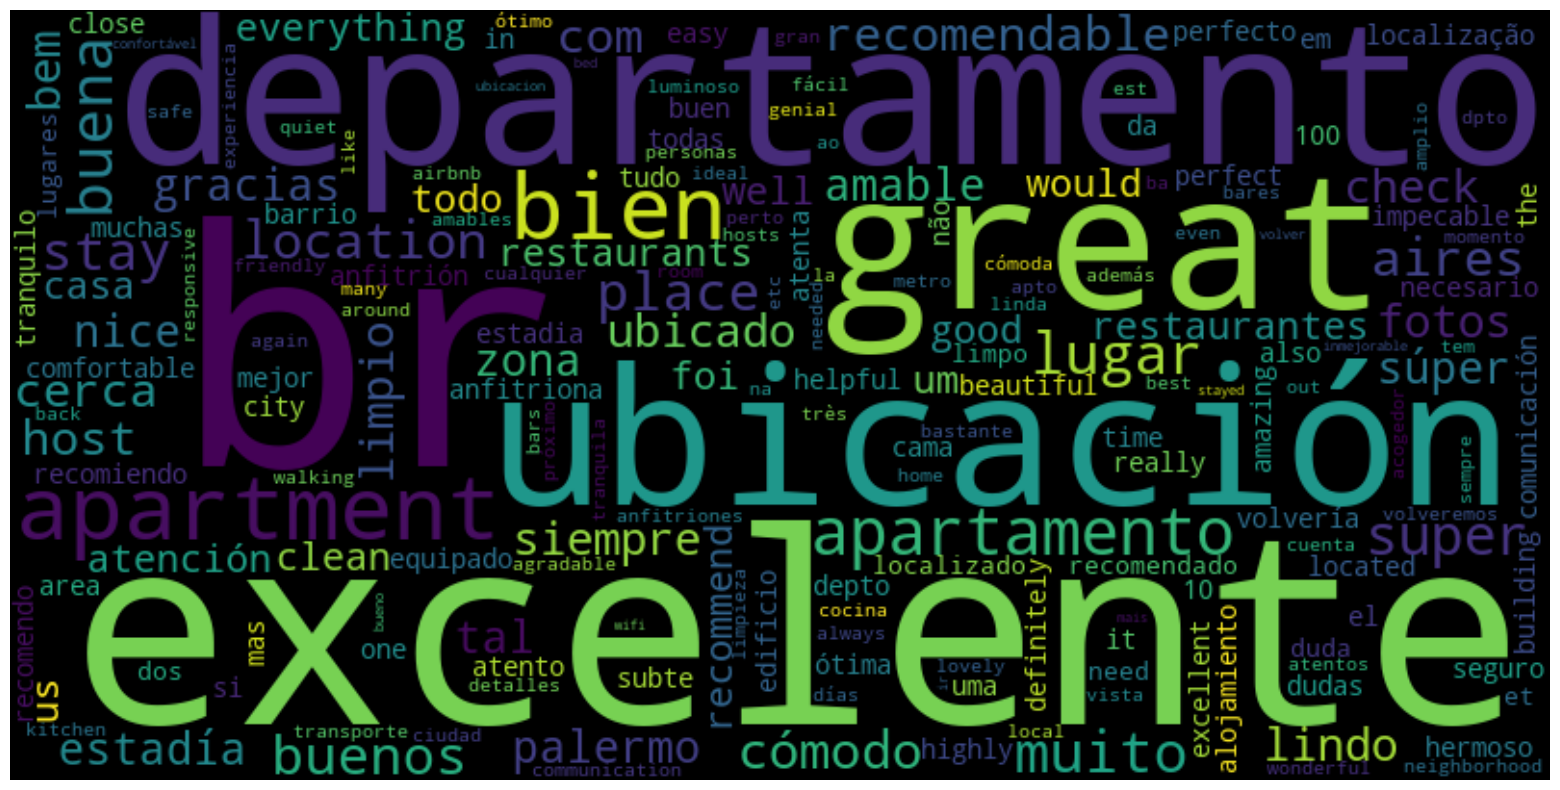

In [45]:
cvec_dict = dict(zip(cvec_df.words, cvec_df.counts))

wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=cvec_dict)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Conclusiones

Hemos analizado los datos referentes a la ciudad de Buenos Aires en relación al alojamiento, la seguridad, los anfitriones, precio y disponibilidad, además de hacer un filtrado sobre las palabras que más se repiten en las reseñas.  
A la vista de los datos analizados podemos ver como Buenos Aires es una ciudad con una gran diversidad cultural, gatronomica y de ocio para disfrutar y que es visitada por gente de todo el mundo. Es una ciudad
Es una ciudad que al cambio sale muy bien de precio, ya que 1€ se corresponde a 0,0027$a, lo que nos hará tner una gran experiencia a un precio muy bajo.

Enlace correspondiente al informe de Power BI y el panel de conclusiones  
https://app.powerbi.com/links/7k2SnhsaRu?ctid=8aebddb6-3418-43a1-a255-b964186ecc64&pbi_source=linkShare  
https://app.powerbi.com/groups/me/dashboards/e9025c27-114a-4106-b8e2-d77dc675322e?ctid=8aebddb6-3418-43a1-a255-b964186ecc64&pbi_source=linkShare